In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json
import os

os.chdir("../")
from scripts import utils, alerceanomalies
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.svm import OneClassSVM
import distclassipy as dcpy
from distclassipy.anomaly import DistanceAnomaly
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, OutlierMixin
epsilon = np.finfo(np.float32).eps
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

from IPython.core.display import HTML
from IPython.display import display

import squarify
set3colors = [matplotlib.colors.rgb2hex(x) for x in plt.cm.Set3.colors]
knowncolors = set3colors[:4]
unknowncolors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
unknowncolors = set3colors[4:]+unknowncolors

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [2]:
models_to_test = {
    "DistClassiPy1": DistanceAnomaly(
        cluster_agg='min',
        metric_agg='median',
        normalize_scores=True
    ),
    "DistClassiPy2": DistanceAnomaly(
        cluster_agg='min',
        metric_agg='mean',
        normalize_scores=True
    ),
    "DistClassiPy3": DistanceAnomaly(
        cluster_agg='min',
        metric_agg='min',
        normalize_scores=True
    ),
    "DistClassiPy4": DistanceAnomaly(
        cluster_agg='min',
        metric_agg='percentile_25',
        normalize_scores=True
    ),
    "DistClassiPy5": DistanceAnomaly(
        cluster_agg='median',
        metric_agg='median',
        normalize_scores=True
    ),
    "DistClassiPy6": DistanceAnomaly(
        cluster_agg='median',
        metric_agg='mean',
        normalize_scores=True
    ),
    "DistClassiPy7": DistanceAnomaly(
        cluster_agg='median',
        metric_agg='min',
        normalize_scores=True
    ),
    "DistClassiPy8": DistanceAnomaly(
        cluster_agg='median',
        metric_agg='percentile_25',
        normalize_scores=True
    ),
    "DistClassiPy9": DistanceAnomaly(
        cluster_agg='mean',
        metric_agg='median',
        normalize_scores=True
    ),
    "DistClassiPy10": DistanceAnomaly(
        cluster_agg='mean',
        metric_agg='mean',
        normalize_scores=True
    ),
    "DistClassiPy11": DistanceAnomaly(
        cluster_agg='mean',
        metric_agg='min',
        normalize_scores=True
    ),
    "DistClassiPy12": DistanceAnomaly(
        cluster_agg='mean',
        metric_agg='percentile_25',
        normalize_scores=True
    ),
}

In [3]:
features1 = pd.read_parquet("data/allfeatures.parquet")

features2 = pd.read_parquet("data/otherclassobjs_features.parquet")
features2.index.name = "snid"
features2cl = pd.read_parquet("data/otherclassobjs.parquet")
features2cl.index.name = "snid"
features2["class"] = features2cl["class"]
assert (features2.index == features2cl.index).all()
del(features2cl)

features3 = pd.read_parquet("data/otherclassobjs_features_23AUG.parquet")
features3.index.name = "snid"
features3cl = pd.read_parquet("data/otherclassobjs_23AUG.parquet")
features3cl.index.name = "snid"
features3["class"] = features3cl["class"]
assert (features3.index == features3cl.index).all()
del(features3cl)

commondat = pd.concat([features1,features2,features3])
commondat=commondat[~commondat.index.duplicated()]
del(features1, features2, features3)

assert (len(commondat.index) == len(commondat.index.unique()))

In [4]:
new_knowns = ['EB', 'DSCT', 'RRL', 'CEP']
new_unknowns = ['PISN-STELLA_HYDROGENIC', 'PISN-MOSFIT', 'uLens-Single_PyLIMA',
        'TDE', 'SNIcBL+HostXT_V19', 'KN_B19', 'uLens-Binary', 'SL-SNII',
        'SNIc-Templates', 'SLSN-I+host', 'SNIa-SALT3', 'SNIb-Templates',
        'SNII+HostXT_V19', 'SNIa-91bg', 'SL-SNIb', 'Mdwarf-flare', 'ILOT',
        'KN_K17', 'CART', 'SNIIb+HostXT_V19', 'SNIb+HostXT_V19', 'SL-SN1a',
        'SNII-NMF', 'SNIIn+HostXT_V19', 'SNII-Templates',
        'SNIc+HostXT_V19', 'SNIax', 'SNIIn-MOSFIT', 'uLens-Single-GenLens',
        'PISN-STELLA_HECORE', 'AGN', 'SLSN-I_no_host', 'SL-SNIc',
        'dwarf-nova']

features_to_use = [
    # 'SPM_A_g', 'SPM_gamma_g', 'SPM_beta_g', 'SPM_tau_rise_g', 'SPM_tau_fall_g',
    # 'SPM_A_r', 'SPM_gamma_r', 'SPM_beta_r', 'SPM_tau_rise_r', 'SPM_tau_fall_r'
    'SPM_A_g', 'SPM_gamma_g', 'SPM_beta_g', 'SPM_tau_rise_g', 'SPM_tau_fall_g',
    'SPM_A_r', 'SPM_gamma_r', 'SPM_beta_r', 'SPM_tau_rise_r', 'SPM_tau_fall_r',
    'SPM_A_i', 'SPM_gamma_i', 'SPM_beta_i', 'SPM_tau_rise_i', 'SPM_tau_fall_i',
    'SPM_A_z', 'SPM_gamma_z', 'SPM_beta_z', 'SPM_tau_rise_z', 'SPM_tau_fall_z',
    'SPM_A_Y', 'SPM_gamma_Y', 'SPM_beta_Y', 'SPM_tau_rise_Y', 'SPM_tau_fall_Y',
]



# Could use features we know are better for the 4 variable star classification
# but don't want to bias. additionally, the above features are simple and general
# and have very little NaNs.

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [6]:
all_classes = np.concatenate([new_knowns, new_unknowns])
full_df = commondat[commondat['class'].isin(all_classes)]
full_df = full_df.loc[:, list(features_to_use) + ["class"]].dropna(subset=features_to_use)
full_df = full_df[~full_df.index.duplicated(keep='first')]

# full_df['status'] = np.where(full_df['class'].isin(new_knowns), 'normal', 'anomalous')
# will use this for stratification

full_inlier_df = full_df[full_df["class"].isin(new_knowns)]
smallest_class_count = full_inlier_df["class"].value_counts().min()
full_outlier_df = full_df[full_df["class"].isin(new_unknowns)]

outlier_counts = full_outlier_df["class"].value_counts()
num_outlier_classes = len(outlier_counts)

In [7]:
N_RUNS = 5

# kf = KFold(n_splits=N_RUNS)

all_run_results = []

for i in tqdm(range(N_RUNS), desc="Running Experiments"):
    current_seed = seed_val+i
    
    # Balance inlier classes
    keep_indices = full_inlier_df.groupby("class").sample(smallest_class_count, random_state=current_seed).index
    inlier_df=full_inlier_df[full_inlier_df.index.isin(keep_indices)]
    thrown_inlier_df = inlier_df[~inlier_df.index.isin(keep_indices)]
    
    # Split balanced inliers into train/test
    inlier_train_df, inlier_test_df = train_test_split(
        inlier_df, test_size=0.5, random_state=current_seed,
        stratify=inlier_df['class'],
    )    
    
    tot_inliers_in_test = inlier_test_df["class"].value_counts().sum()
    frac_outliers_in_test = 0.9
    tot_outliers_in_test = int(frac_outliers_in_test * tot_inliers_in_test)

    samples_to_take = {}
    active_classes = list(outlier_counts.index)
    remaining_to_sample = tot_outliers_in_test
    available_counts = outlier_counts.copy()
    
    while True:
        if not active_classes:
            break
    
        ideal_samples_per_class = remaining_to_sample / len(active_classes)
        
        # Find classes that have fewer members than the ideal number
        small_classes = [
            c for c in active_classes if available_counts[c] < ideal_samples_per_class
        ]
    
        if not small_classes:
            # No more small classes, proceed to final distribution
            break
    
        # For each small class, take all available members
        for class_name in small_classes:
            num_to_take = available_counts[class_name]
            samples_to_take[class_name] = num_to_take
            
            remaining_to_sample -= num_to_take
            active_classes.remove(class_name)
    
    # Distribute the rest of the samples among the larger classes
    if active_classes:
        base_samples = remaining_to_sample // len(active_classes)
        remainder = remaining_to_sample % len(active_classes)
    
        for i, class_name in enumerate(active_classes):
            if i < remainder:
                samples_to_take[class_name] = base_samples + 1
            else:
                samples_to_take[class_name] = base_samples
    
    # Perform the actual sampling
    sampled_dfs = []
    for class_name, n_samples in samples_to_take.items():
        class_df = full_outlier_df[full_outlier_df['class'] == class_name].sample(n=n_samples, random_state=current_seed)
        sampled_dfs.append(class_df)
    
    # Combine all the sampled data into a final DataFrame
    final_sampled_df = pd.concat(sampled_dfs)

    X_train_df = inlier_train_df[features_to_use]
    y_train_df = inlier_train_df['class']

    X_test_df = pd.concat([inlier_test_df[features_to_use], final_sampled_df[features_to_use]]).sample(frac=1, random_state=current_seed)
    y_test_df = pd.concat([inlier_test_df['class'], final_sampled_df['class']]).loc[X_test_df.index]

    results_df = pd.DataFrame(index=X_test_df.index)
    results_df['class'] = y_test_df
    mask = results_df['class'].isin(new_knowns)
    results_df['status'] = np.where(mask, 'normal', 'anomalous')

    for model_name, model_template in models_to_test.items():
        model = clone(model_template)

        if 'random_state' in model.get_params():
            model.set_params(random_state=current_seed)
        
        if "DistClassiPy" in model_name or "ClassSVDD" in model_name:
            model.fit(X_train_df.to_numpy(), y_train_df.to_numpy())
        else:
            model.fit(X_train_df.to_numpy())
            
        scores = model.decision_function(X_test_df.to_numpy())
        if model_name in ["IsolationForest", "LocalOutlierFactor", "OneClassSVM"]:
            scores = -scores

        results_df[f'score_{model_name}'] = scores
        
    all_run_results.append(results_df)

Running Experiments:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
# import pickle
# with open("06. paper neurips mlps/results/exp1_results.pkl","wb") as fp:
#     pickle.dump(all_run_results, fp)

In [9]:
# import pickle
# with open("06. paper neurips mlps/results/exp1_results.pkl","rb") as fp:
#     all_run_results=pickle.load(fp)

In [10]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.font_manager as font_manager

fpath = Path(mpl.get_data_path(), "/Users/sidchaini/Downloads/computer-modern/cmunrm.ttf")

In [12]:
def analysis_with_errors(all_fold_results, budget=300, metric='purity'):
    for model_name in tqdm(models_to_test.keys(), desc="Analyzing Models", leave=False):
        
        fold_curves = []
        max_anom_in_folds = [fold_res['status'].value_counts().get('anomalous', 0) for fold_res in all_fold_results]
        
        budget = min(budget, min(max_anom_in_folds))
        top_ns = np.arange(1, budget + 1)
        
        for fold_res in all_fold_results:
            curve = []
            topresults_df = fold_res.sort_values(by=f"score_{model_name}", ascending=False)
            
            for i in top_ns:
                top_candidates = topresults_df.head(i)
                
                if metric == 'purity':
                    valcounts = top_candidates['status'].value_counts(normalize=True)
                    value = valcounts.get("anomalous", 0)
                elif metric == 'diversity':
                    anomalous_found = top_candidates[top_candidates["status"] == "anomalous"]
                    value = len(anomalous_found["class"].unique())
                else:
                    raise ValueError("Metric must be 'purity' or 'diversity'")
                curve.append(value)
            fold_curves.append(curve)
        
        # Convert list of curves to a 2D numpy array for easy stats
        fold_curves_arr = np.array(fold_curves)
        
        mean_curve = np.mean(fold_curves_arr, axis=0)
        std_curve = np.std(fold_curves_arr, axis=0)
        
        # Plotting
        lw = 3.25 if "distclassipy" in model_name.lower() else 1.75
        p = plt.plot(top_ns, mean_curve, label=model_name, linewidth=lw)
        plt.fill_between(top_ns, 
                         np.clip(mean_curve - std_curve,a_min=0, a_max=1), 
                         np.clip(mean_curve + std_curve,a_min=0, a_max=1), 
                         color=p[0].get_color(), alpha=0.1)

    if metric == 'purity':
        plt.ylabel("Purity", fontsize=16, font=fpath)
    elif metric == 'diversity':
        plt.ylabel("New Classes Discovered", fontsize=16, font=fpath)
        
    plt.xlabel("Follow-up Budget (No. of sources)", fontsize=16, font=fpath)
    plt.gca().tick_params(axis='both', which='major', labelsize=16)
    plt.gca().tick_params(axis='both', which='minor', labelsize=12)
    font = font_manager.FontProperties(fname=fpath)
    legend = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12, prop=font)
    
    for text in legend.get_texts():
        if "distclassipy" in text.get_text().lower():
            text.set_fontweight('bold')

    plt.grid(True)
    plt.title("EXP1: Novel Phenomena Hunt ELAsTiCC", font=fpath)
    return plt.gcf()


--- Purity vs. Budget Plot ---


Analyzing Models:   0%|          | 0/12 [00:00<?, ?it/s]

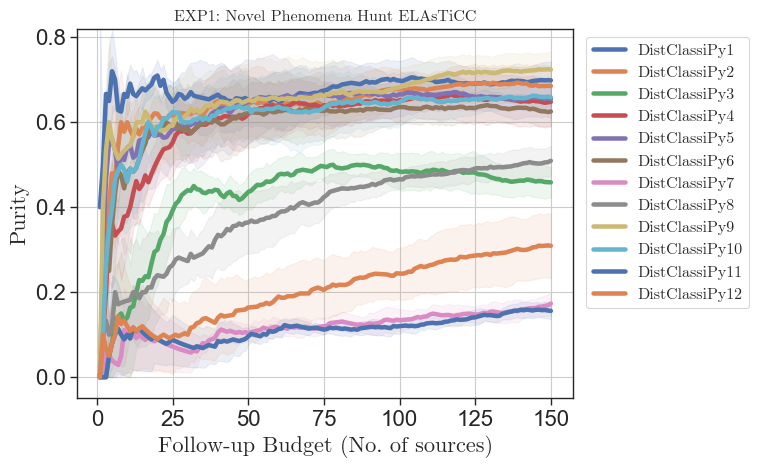


--- Diversity of Discovery Plot ---


Analyzing Models:   0%|          | 0/12 [00:00<?, ?it/s]

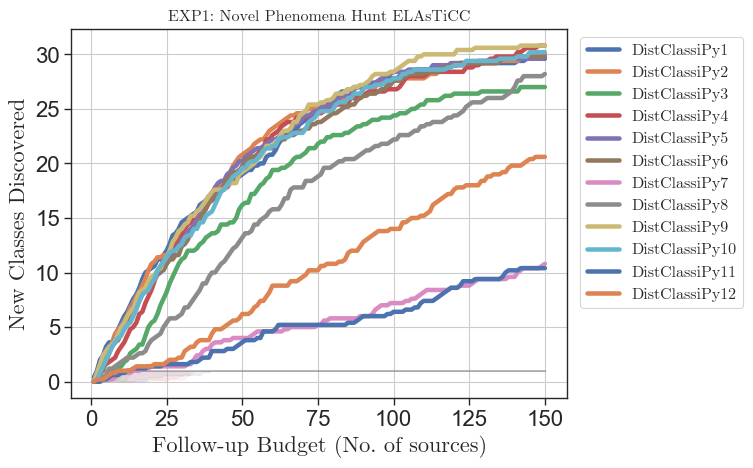

In [13]:
print("\n--- Purity vs. Budget Plot ---")
fig = analysis_with_errors(all_run_results, budget=150, metric='purity')
plt.ylim(-0.05,0.82)
plt.show()

print("\n--- Diversity of Discovery Plot ---")
fig = analysis_with_errors(all_run_results, budget=150, metric='diversity')
plt.show()


--- Purity vs. Budget Plot ---


Analyzing Models:   0%|          | 0/12 [00:00<?, ?it/s]

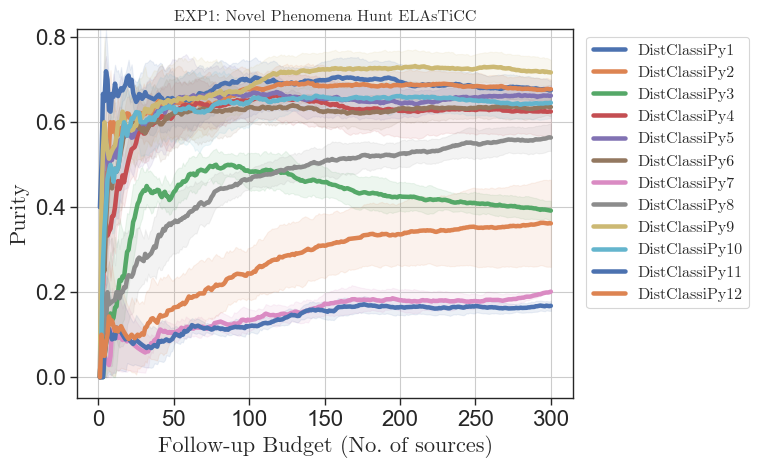


--- Diversity of Discovery Plot ---


Analyzing Models:   0%|          | 0/12 [00:00<?, ?it/s]

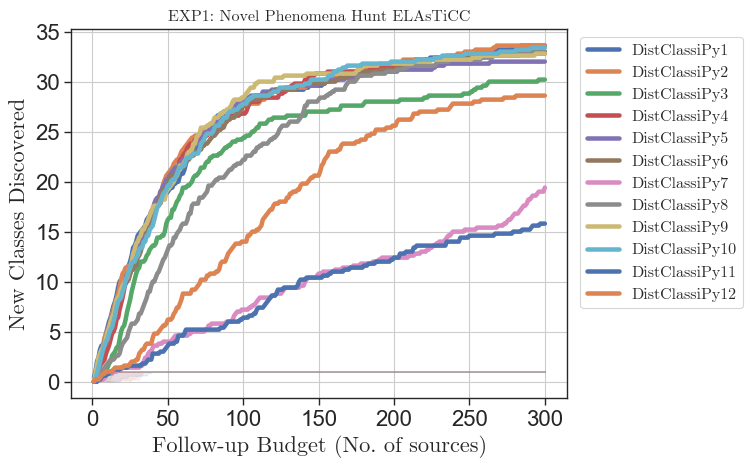

In [14]:
print("\n--- Purity vs. Budget Plot ---")
fig = analysis_with_errors(all_run_results, budget=300, metric='purity')
plt.ylim(-0.05,0.82)
plt.show()

print("\n--- Diversity of Discovery Plot ---")
fig = analysis_with_errors(all_run_results, budget=300, metric='diversity')
plt.show()


--- Purity vs. Budget Plot ---


Analyzing Models:   0%|          | 0/12 [00:00<?, ?it/s]

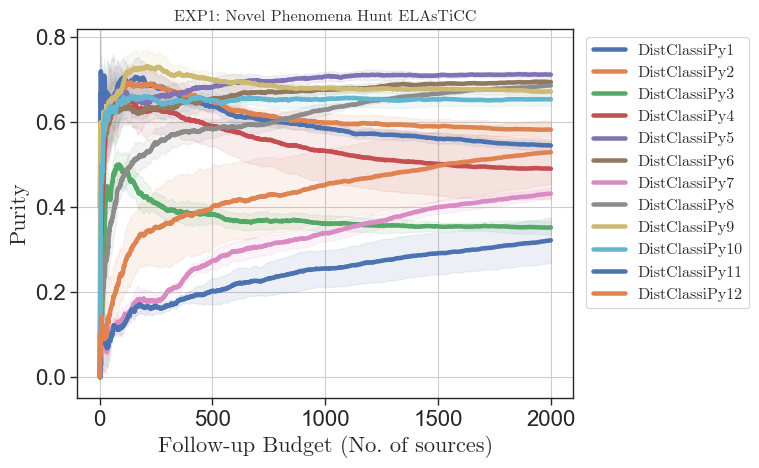


--- Diversity of Discovery Plot ---


Analyzing Models:   0%|          | 0/12 [00:00<?, ?it/s]

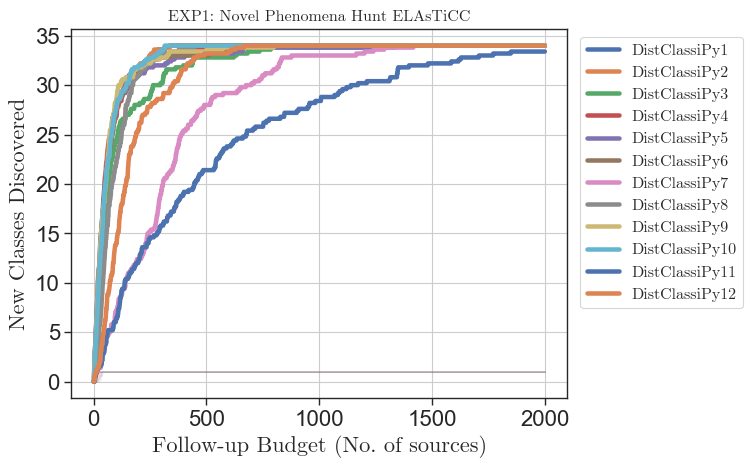

In [15]:
print("\n--- Purity vs. Budget Plot ---")
fig = analysis_with_errors(all_run_results, budget=2000, metric='purity')
plt.ylim(-0.05,0.82)
plt.show()

print("\n--- Diversity of Discovery Plot ---")
fig = analysis_with_errors(all_run_results, budget=2000, metric='diversity')
plt.show()
